<a href="https://colab.research.google.com/github/mdaftary/Word2Vec-Algo/blob/main/Word2Vec_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




![Word2Vec](https://serokell.io/files/qz/qzp39hlo.pic_7_Word2Vec.png)
Image credits: https://serokell.io/blog/word2vec

# **Section 1** Introduction and motivation to Word2Vec (no tasks to complete)

Have you ever wondered how large language models like ChatGPT and BARD process text?
In this programming assignment, we are going to explore Word2Vec, a popular algorithm used in natural language processing (machine learning on text) for models to "understand" the human language.  We will use MLP to build our very own Word2Vec model.

The need for these algorithms comes from the fact that machine learning models operate on numbers but not text.  Because of this, before you train your text model, you first need a method to map your text into numbers.

Perhaps the most naive way to do so is by assigning a random number to each word.  For example, let's say we have the following text (taken from Dr Suess, Green Eggs and Ham):

<center>

> *I do not like them here or there.* <br>
> *I do not like them anywhere.* <br>
> *I do not like green eggs and ham.*
</center>

We *could* just assign numbers randomly, and one such mapping could be

```python
word_to_index = {
  'I': 0,     'them': 1,     'here': 2,    ...
  'there': 9, 'eggs': 10,    'do': 11      ...
  'ham': 16
}
```

but the problem with this approach is that it does not encode *any* information about the meanings of the words at all.  For example, 'eggs' and 'ham' are similar words (both are food), but have vastly different values (eggs is 10, ham is 16).  

To illustrate the problem with this, let's say you give your model the word 'green', in the hope that it predicts the next word to be 'eggs'.  After training for a few epochs, it predicts the next word to be 'I', which is obviously wrong.  You train your model for a few more epochs and re-feed the word 'green'.  Now it predicts the next word to be 'ham'.  You want to tell the model that it did a better job than before, but since the numbers associated with each word are assigned randomly, you cannot use the difference between the numbers to tell your model that it got closer to the true answer.  In other words, you are unable to tell your model anything other than "you got it right" or "you got it wrong".  This makes training your model much harder.

A good mapping should, therefore, map similar words close to each other, which is the goal of Word2Vec.  The following *2D semantic space* shows an example of what we want to achieve.

*(If the image does not load, run the code cell for "2D Sematic Space" in the appendix of the notebook to generate the image)*

![img](https://course.cse.ust.hk/comp2211/assignments/pa2/images/2d_semantic_space.png)

Using the two *semantic features* "animal" and "food", we are able to encode the words above in a much more meaningful way.  Each word is now represented by a vector in $\mathbb{R}^2$ (a list of 2 real numbers) and positioned such that similar words are clustered together:

<center>

|           | food (x-axis) | animal (y-axis) |
|-----------|:-------------:|:---------------:|
| llama     |      0.25     |       5.25      |
| dog       |      0.5      |        5        |
| frog      |      0.75     |       4.75      |
| coriander |       5       |        1        |
| ...       |      ...      |       ...       |

</center>

**Question**: Where do you think the words "rat", "lamb", and "grapes" would be placed?

This is already a great step up from giving each word random values.  But why stop at just 2 semantic features?  Let's say we want to add the words "cat", "rabbit" and "hamster" to the semantic space.  They would probably be placed in the top-left corner, together with "llama", "dog", and "frog".  But obviously, cats, dogs, rabbits and hamsters have something else in common: they are all pets!  So, it would make sense to add a "pet" semantic feature, enriching our semantic space.  The result may look something like the following picture:

*(If the image does not load, run the code cell for "3D Sematic Space" in the appendix of the notebook to generate the image)*

![img](https://course.cse.ust.hk/comp2211/assignments/pa2/images/3d_semantic_space.png)

Now, we have encoded each word as a vector in $\mathbb{R}^3$ (a list of 3 real numbers):

<center>

|           | food (x-axis) | animal (y-axis) | pet (z-axis) |
|-----------|:-------------:|:---------------:|:------------:|
| llama     |      0.25     |       5.25      | 0 |
| dog       |      0.5      |        5        | 5 |
| frog      |      0.75     |       4.75      | 1 |
| coriander |       5       |        1        | 0 |
| ...       |      ...      |       ...       |...|

</center>

But there is no reason to stop at 3 semantic features.  Evidently, by continuously adding even more semantic features (dimensions), our Word2Vec model can become even more expressive and capable of capturing the different intertwined meanings of our vocabulary.  

Typically, large language models use Word2Vec models with 300 dimensions - a list of 300 real numbers for *each* vocabulary!  What's more, Word2Vec models are trained in an unsupervised manner.  This means that we do not supply the labels (i.e. "food", "animal", "pet") to the dimensions.
 Instead, we ask the model to learn them itself.

There are 2 methods we can use to learn the dimensions: the **continuous bag of words** (CBOW) approach and the **skip-gram** approach.  The idea of both approaches is to train the model by feeding it a huge amount of text (for example, all Wikipedia articles), but they differ in how we represent the context words.  Let's illustrate the differences by considering the following sentence:

> The Sydney Opera House is a multi-venue performing arts centre in Sydney.

In the **continuous bag of words** approach, **the goal is to predict *one* target word from a few context words**.  So, for each target word in the sentence, we look up *n* context words (in this programming assignment, we will take *n=2*) to the left and right of the target word, and construct a context table, as follows:

*Note:  the size of n is formally called the "window size".*

<center>

| target word (y) | context words (x)         |
|:-----------:|------------------------|
|     the     | sydney, opera          |
|    sydney   | the, opera, house      |
|    opera    | the, sydney, house, is |
|    house    | sydney, opera, is, a   |
|      is     | opera, house, a, multi |
|     ...     | ...                    |

</center>

In the **skip-gram** approach, **the goal is to predict a few context words *given* one target word**.  So, for each target word in the sentence, we also look up *n* context words (*n=2*), but each context word is recorded separately, as follows:

<center>

| target word (x) | context words (y)|
|:-----------:|:-------------:|
|     the     |     sydney    |
|     the     |     opera     |
|    sydney   |      the      |
|    sydney   |     opera     |
|    sydney   |     house     |
|    opera    |      the      |
|    opera    |     sydney    |
|    opera    |     house     |
|    opera    |       is      |
|    house    |     sydney    |
|     ...     |      ...      |

</center>

In the continuous bag of words approach, we feed the model the context words and ask it to predict one target word.  In the skip-gram approach, we feed the model one target word and ask it to predict context words.

The model architecture is as follows:

$$
\begin{align*}
y &= \text{softmax}\big(T_2 (T_1 x)\big), \hspace{1em}\text{where} \\
x &\text{ is a one-hot encoded vector in } \mathbb{R}^{\text{num_vocabs}} \\
T_1 &\text{ is a linear transformation from } \mathbb{R}^{\text{num_vocabs}}\to\mathbb{R}^{300} \\
T_2 &\text{ is a linear transformation from } \mathbb{R}^{300}\to\mathbb{R}^{\text{num_vocabs}} \\
y &\text{ is a vector in }\mathbb{R}^{\text{num_vocabs}}
\end{align*}
$$

*(The appendix of this notebook has a quick review on one-hot encoding)*

Put simply, the model consists of 2 layers.
- The first layer takes each word and outputs a vector in $\mathbb{R}^{300}$.
- The second layer takes these vectors and maps them back down to $\mathbb{R}^{\text{num_vocabs}}$.  The output is run through a softmax function to determine which word the model predicts.

Note that the model architecture doesn't change no matter if we use the continuous bag of words or skip-gram approach, the only difference lies in how we encode the input words.

At this point, you may wonder how predicting context words can help us "group similar words together".  Notice that our ultimate goal is to find a function that maps words to vectors of 300 dimensions and not predict context words, and in fact, our $T_1$ linear layer does exactly that:  it takes in a one-hot vector representing the word and outputs a vector in 300 dimensions.


In the following tasks, we will build our own Word2Vec model.  For easier debugging and to test if the model was built correctly, we will train our model using a short paragraph instead of the whole Wikipedia articles dataset.  The short paragraph chosen is taken from the Wikipedia page on [*open sets*](https://en.wikipedia.org/wiki/Open_set) in mathematics.

# **Section 2** Generating a simple dataset for training (3 tasks to complete)

The first step is cleaning the text by removing punctuation marks and capitalising.  This step has been done for you.

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 1:  Clean text.  Remove punctuations, caps #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

# do not edit the text below or the cleaning may not work!
if __name__ == '__main__':

  text = '''In mathematics, an open set is a generalization of an open interval in the real line.
  In a metric space (a set along with a distance defined between any two points),
  an open set is a set that, along with every point P, contains all points that are sufficiently near to P
  (that is, all points whose distance to P is less than some value depending on P).
  More generally, an open set is a member of a given collection of subsets of a given set,
  a collection that has the property of containing every union of its members, every finite intersection of its members,
  the empty set, and the whole set itself. A set in which such a collection is given is called a topological space,
  and the collection is called a topology. These conditions are very loose, and allow enormous flexibility in the choice of open sets.
  For example, every subset can be open (the discrete topology), or no subset can be open except the space itself and the empty set
  (the indiscrete topology). In practice, however, open sets are usually chosen to provide a notion of nearness that is
  similar to that of metric spaces, without having a notion of distance defined. In particular,
  a topology allows defining properties such as continuity, connectedness, and compactness, which were originally defined by means of a distance.'''

  import re  # python's regular expression library.  A powerful library for text manipulation
  cleaning = text.lower()  # CAPS -> caps
  cleaning = re.sub(r'\n', ' ', cleaning)  # replace the newline characters with a space
  cleaning = re.sub(r'[^a-z0-9 -]', '', cleaning)  # replace all characters except letters, numbers, space bars and hyphens with an empty string
  cleaned_text = re.sub(' +', ' ', cleaning)  # replace multiple spaces with one space

  print(cleaned_text)

in mathematics an open set is a generalization of an open interval in the real line in a metric space a set along with a distance defined between any two points an open set is a set that along with every point p contains all points that are sufficiently near to p that is all points whose distance to p is less than some value depending on p more generally an open set is a member of a given collection of subsets of a given set a collection that has the property of containing every union of its members every finite intersection of its members the empty set and the whole set itself a set in which such a collection is given is called a topological space and the collection is called a topology these conditions are very loose and allow enormous flexibility in the choice of open sets for example every subset can be open the discrete topology or no subset can be open except the space itself and the empty set the indiscrete topology in practice however open sets are usually chosen to provide a n

Next, use the cleaned text to create the following **four** variables:

<center>

| variable name  | datatype       | description                                         |
|----------------|----------------|-----------------------------------------------------|
|`words_in_order`|`list[str]`     | a list of all the words (which are separated by spaces) in the order they appeared in `cleaned`   |
|`num_vocabs`    |`int`           | the number of unique words (i.e. vocabs)            |
|`word_to_index` |`dict[str, int]`| a dictionary mapping each unique word to an integer.  The mapping should follow alphabetic order |
|`index_to_word` |`dict[int, str]`| a dictionary mapping each integer back to the word  |

</center>

*(This cell can be deleted)*  For example, for the cleaned text
> the sydney opera house is a multi-venue performing arts centre in sydney

the four variables may look as follows:

<center>

| variable name | content                                                                                                                               |
|---------------|---------------------------------------------------------------------------------------------------------------------------------------|
|`words_in_order`|`['the', 'sydney', 'opera', 'house', 'is', 'a', 'multi-venue', 'performing', 'arts', 'centre', 'in', 'sydney']`|
|`num_vocabs`   |`11`                                                                                                                                   |
|`word_to_index`|`{'a': 0, 'arts': 1, 'centre': 2, 'house': 3, 'in': 4, 'is': 5, 'multi-venue': 6, 'opera': 7, 'performing': 8, 'sydney': 9, 'the': 10}`|
|`index_to_word`|`{0: 'a', 1: 'arts', 2: 'centre', 3: 'house', 4: 'in', 5: 'is', 6: 'multi-venue', 7: 'opera', 8: 'performing', 9: 'sydney', 10: 'the'}`|

</center>

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 2:  Compile corpus, create word_to_index and index_to_word #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def generate_variables(cleaned_text):
  """
  Generates the four required variables above.
  Args:
    cleaned_text: the cleaned text in the step above
  Returns:
    words_in_order, num_vocabs, word_to_index, index_to_word
  """

  ### TO DO ###
  words_in_order = cleaned_text.split()
  words_set = sorted(set(words_in_order))
  num_vocabs = len(words_set)
  word_to_index = dict(map(reversed, enumerate(words_set)))
  index_to_word = dict(enumerate(words_set))

  return words_in_order,num_vocabs,word_to_index,index_to_word

if __name__ == '__main__':
  words_in_order, num_vocabs, word_to_index, index_to_word = generate_variables(cleaned_text)


Next, generate datasets for both the skip-gram approach and the continuous bag of words approach.  Complete the following **two** functions,

<center>

| function name | parameter name | parameter datatype | return type
|---------------------------------|------------------------------------------|----------------------------|-------------------------------|
| `generate_training_data_skipgram` | `words_in_order`<br> `word_to_index`<br> `window_size` | `ls[str]`<br> `dict[str, int]`<br> `int` | `tuple(np.ndarray, np.ndarray)` |            |
| `generate_training_data_cbow`     | `words_in_order`<br> `word_to_index`<br> `window_size` | `ls[str]`<br> `dict[str, int]`<br> `int` | `tuple(np.ndarray, np.ndarray)` |

</center>

and create the following **four** variables:

<center>

| variable name | datatype     | description                                                                              |
|---------------|--------------|------------------------------------------------------------------------------------------|
| `x_cbow`      | `np.ndarray` | 2D array of the cbow **context** word table, where each word is represented by its index.  Use `window_size = 2`      |
| `y_cbow`      | `np.ndarray` | 1D array of the cbow **target** word table, where each word is represented by its index.  Use `window_size = 2`     |
| `x_skipgram`  | `np.ndarray` | 1D array of the skipgram **target** word table, where each word is represented by its index.  Use `window_size = 2`  |
| `y_skipgram`  | `np.ndarray` | 1D array of the skipgram **context** word table, where each word is represented by its index.  Use `window_size = 2` |

</center>

Note that in case the target word has fewer context words than usual `window_size*2` (e.g. the first, second, second last, and last words with respect to `window_size=2`), you need to 'pad' the context word lists by adding -1 at the end.

*(This cell can be deleted)*  For example, using the results from STEP 2, the four variables may look as follows:

<center>

| variable name | content                                                                                                                                                                       |
|---------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `x_cbow`      | `[[ 9  7 -1 -1] [10  7  3 -1] [10  9  3  5] [ 9  7  5  0]  [ 7  3  0  6] [ 3  5  6  8] [ 5  0  8  1] [ 0  6  1  2]  [ 6  8  2  4] [ 8  1  4  9] [ 1  2  9 -1] [ 2  4 -1 -1]]` |
| `y_cbow`      | `[10  9  7  3  5  0  6  8  1  2  4  9]`                                                                                                                                       |
| `x_skipgram`  | `[10 10  9  9  9  7  7  7  7  3  3  3  3  5  5  5  5  0  0  0  0     6  6  6  6  8  8  8  8  1  1  1  1  2  2  2  2  4  4  4  9  9]`                                          |
| `y_skipgram`  | `[ 9  7 10  7  3 10  9  3  5  9  7  5  0  7  3  0  6  3  5  6  8     5  0  8  1  0  6  1  2  6  8  2  4  8  1  4  9  1  2  9  2  4]`                                          |

</center>

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 3:  Generate training data part 1  #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

import numpy as np

def generate_training_data_cbow(words_in_order, word_to_index, window_size):
    """
    Generates the target word table and context word table based on the continuous bag of words approach.
    The table should contain the index of the word instead of the word itself.
    For words in the start and end of the whole text where the number of context words are less than window_size * 2,
    fill up the remaining entries of the array with 'special number' -1 instead
    Args:
      words_in_order: the list of words appearing in order that we created in the previous step
      word_to_index: the dictionary that we created in the previous step
      window_size: how far we scan for context words
    Returns:
      a tuple of 2 numpy arrays
    """
    ### TO DO ###
    len_words = len(words_in_order)
    cbow_data = np.full((len_words,window_size*2), -1)
    y_cbow = np.empty((len_words,),dtype = int)
    for i , data in enumerate(words_in_order):
      y_cbow[i] = word_to_index[data]
      count = 0
      for back in range(min((i,window_size)),0,-1):
        cbow_data[i,count] = word_to_index[words_in_order[i-back]]
        count += 1
      for front in range(min((window_size,len_words-i-1))):
        cbow_data[i,count] = word_to_index[words_in_order[i+front+1]]
        count += 1
    return (cbow_data,y_cbow)


def generate_training_data_skipgram(words_in_order, word_to_index, window_size):
    """
    Generates the target word table and context word table based on the skipgram approach.
    The table should contain the index of the word instead of the word itself.\
    Args:
      words_in_order: the list of words appearing in order that we created in the previous step
      word_to_index: the dictionary that we created in the previous step
      window_size: how far we scan for context words
    Returns:
      a tuple of 2 numpy arrays
    """
    ### TO DO ###
    len_words = len(words_in_order)
    x_skipgram = []
    y_skipgram = []
    for i, data in enumerate(words_in_order):
      for back in range(min((i,window_size)),0,-1):
        x_skipgram.append(word_to_index[data])
        y_skipgram.append(word_to_index[words_in_order[i-back]])
      for front in range(min((window_size,len_words-i-1))):
        x_skipgram.append(word_to_index[data])
        y_skipgram.append(word_to_index[words_in_order[i+front+1]])
    return (np.array(x_skipgram),np.array(y_skipgram))

if __name__ == '__main__':
  x_cbow, y_cbow = generate_training_data_cbow(words_in_order, word_to_index, 2)
  x_skipgram, y_skipgram = generate_training_data_skipgram(words_in_order, word_to_index, 2)
  '''
  print(x_cbow)
  print(x_cbow.shape)
  print(y_cbow)
  print(y_cbow.shape)
  print(x_skipgram)
  print(x_skipgram.shape)
  print(y_skipgram)
  print(y_skipgram.shape)
  '''

Finally, convert the variables `x_skipgram`, `y_skipgram`, `x_cbow` and `y_cbow` created in the previous step to their one-hot representations. Complete the following **two** functions,

<center>

| function name              | parameter name        | parameter datatype    | return type  |
|----------------------------|-----------------------|-----------------------|--------------|
| `one_hot`                  | `arr`<br>`num_vocabs` | `np.ndarray`<br>`int` | `np.ndarray` |
| `one_hot_multicategorical` | `arr`<br>`num_vocabs` | `np.ndarray`<br>`int` | `np.ndarray` |

</center>

and create the following **four** variables:

<center>

| variable name     | datatype     | description                                                      |
|-------------------|--------------|------------------------------------------------------------------|
| `x_cbow_1hot`     | `np.ndarray` | a 2D array containing the multicategorical one-hot representation of `x_cbow`     |
| `y_cbow_1hot`     | `np.ndarray` | a 2D array containing the one-hot representation of `y_cbow`     |
| `x_skipgram_1hot` | `np.ndarray` | a 2D array containing the one-hot representation of `x_skipgram` |
| `y_skipgram_1hot` | `np.ndarray` | a 2D array containing the one-hot representation of `y_skipgram` |

</center>

*Note:  it is possible to complete both functions without any loops or comprehensions.* **To score full marks for this task, you must not use explicit loops, comprehensions, or import libraries to help you solve this task.  In other words, solve it using purely vectorization techniques.**  Refer to the grading scheme on this programming assignment's webpage for details on the scoring.

*(This cell can be deleted)*  For example, using the results from STEP 3, the four variables may look as follows:

<center>

| variable name     | content                                                                                                                      |
|-------------------|------------------------------------------------------------------------------------------------------------------------------|
| `x_cbow_1hot`     | `[[0 0 0 0 0 0 0 1 0 1 0]`<br> ` [0 0 0 1 0 0 0 1 0 0 1]`<br> ` [0 0 0 1 0 1 0 0 0 1 1]`<br>  ` ...`<br> ` [0 0 1 0 1 0 0 0 0 0 0]]`     |
| `y_cbow_1hot`     | `[[0 0 0 0 0 0 0 0 0 0 1]`<br> ` [0 0 0 0 0 0 0 0 0 1 0]`<br> ` [0 0 0 0 0 0 0 1 0 0 0]`<br>  ` ...`<br> ` [0 0 0 0 0 0 0 0 0 1 0]]`     |
| `x_skipgram_1hot` | `[[0 0 0 0 0 0 0 0 0 0 1]`<br> ` [0 0 0 0 0 0 0 0 0 0 1]`<br> ` [0 0 0 0 0 0 0 0 0 1 0]`<br>  ` ...`<br> ` [0 0 0 0 0 0 0 0 0 1 0]]` |
| `y_skipgram_1hot` | `[[0 0 0 0 0 0 0 0 0 1 0]`<br> ` [0 0 0 0 0 0 0 1 0 0 0]`<br> ` [0 0 0 0 0 0 0 0 0 0 1]`<br>  ` ...`<br> ` [0 0 0 0 1 0 0 0 0 0 0]]`     |

</center>

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 4:  Generate training data part 2  #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def one_hot(arr, num_vocabs):
  """
  Takes in a 1D array and generates its one-hot representation.
  Args:
    arr: a 1D numpy array
    num_vocabs: the number of unique vocabs
  Returns:
    a 2D numpy array of the one-hot representation of arr
  """
  ### TO DO ###
  onehot_arr = np.zeros((arr.size, num_vocabs))
  onehot_arr[np.arange(arr.size), arr] = 1
  return onehot_arr

def one_hot_multicategorical(arr, num_vocabs):
  """
  Takes in a 2D array and generates its multicategorical one-hot representation.
  Args:
    arr: a 2D numpy array
    num_vocabs: the number of unique vocabs
  Returns:
    a 2D numpy array of the multicategorical one-hot representation of arr
  """
  ### TO DO ###
  #onehot_arr = np.zeros((arr.size[0], num_vocabs))
  num_samples = arr.shape[0]
  max_categories = arr.shape[1]
  arr_1hot = np.zeros((num_samples, max_categories, num_vocabs+1), dtype= int)
  arr_1hot[np.repeat(np.arange(num_samples), max_categories), np.tile(np.arange(max_categories), num_samples), arr.flatten()] = 1
  arr_1hot = np.sum(arr_1hot, axis=1)
  return arr_1hot[:,:-1]



if __name__ == '__main__':
  x_cbow_1hot = one_hot_multicategorical(x_cbow, num_vocabs)
  y_cbow_1hot = one_hot(y_cbow, num_vocabs)
  x_skipgram_1hot = one_hot(x_skipgram, num_vocabs)
  y_skipgram_1hot = one_hot(y_skipgram, num_vocabs)
  print(np.argwhere(x_cbow_1hot[10]))
  print(x_cbow_1hot.shape)
  print(np.argwhere(y_cbow_1hot[20]))
  print(y_cbow_1hot.shape)
  print(np.argwhere(x_skipgram_1hot[30]))
  print(x_skipgram_1hot.shape)
  print(np.argwhere(y_skipgram_1hot[40]))
  print(y_skipgram_1hot.shape)


[[ 5]
 [43]
 [46]
 [63]]
(227, 105)
[[0]]
(227, 105)
[[63]]
(902, 105)
[[43]]
(902, 105)


# **Section 3** Compiling and training your own Word2Vec model (2 tasks to complete)

After generating the dataset, it is time to build and train the model!  Using Keras, and create the following **two** variables,

<center>

| variable name    | datatype           | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|------------------|--------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `model_cbow`     | `keras.Sequential` | A Keras multilayer perceptron model with the following architecture:<br>1st layer: fully connected with `dims_to_learn` units, no activation function and no bias.  Specify the correct input shape.<br>2nd layer: fully connected with softmax activation function and no bias.  Specify the correct number of units.<br>|
| `model_skipgram` | `keras.Sequential` | same as above   |

</center>

Also, compile both `model_cbow` and `model_skipgram` with the `Adam` gradient descent optimizer and the `categorical crossentropy` loss function.

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 5:  Compile model  #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras import Sequential
from keras.layers import Dense

def create_cbow_model(num_vocabs, dims_to_learn=50):
  ### TO DO ###
  #model = Sequential(Dense(dims_to_learn, activation=None, use_bias=False, input_shape = (num_vocabs, ), name="layer1"), Dense(num_units, activation="softmax", use_bias=False, name="layer2"))
  model = Sequential()
  model.add(Dense(units = dims_to_learn, activation = None, use_bias = False, input_shape = (num_vocabs, )))
  model.add(Dense(units = num_vocabs, activation = 'softmax', use_bias = False ))

  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
  return model
def create_skipgram_model(num_vocabs, dims_to_learn=50):
  ### TO DO ###
  '''
  model = Sequential()
  model.add(Dense(units = dims_to_learn, activation = None, use_bias = False, input_shape = (num_vocabs, )))
  model.add(Dense(units = num_vocabs, activation = 'softmax', use_bias = False ))
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  '''
  model = Sequential([
        Dense(dims_to_learn, activation=None, use_bias=False, input_shape=(num_vocabs,)),
        Dense(num_vocabs, activation='softmax', use_bias=False)
    ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

if __name__ == "__main__":
  model_cbow = create_cbow_model(num_vocabs)
  model_cbow.summary()
  model_skipgram = create_skipgram_model(num_vocabs)
  model_skipgram.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                5250      
                                                                 
 dense_1 (Dense)             (None, 105)               5250      
                                                                 
Total params: 10500 (41.02 KB)
Trainable params: 10500 (41.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                5250      
                                                                 
 dense_3 (Dense)             (None, 105)               5250      
                                                                

Train both `model_cbow` and `model_skipgram` with their corresponding training data for 500 epochs.

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 6:  Train model  #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

if __name__ == '__main__':
  epochs = 500
  ### TO DO ###
  model_cbow.fit(x_cbow_1hot, y_cbow_1hot, epochs = epochs)
  model_skipgram.fit(x_skipgram_1hot, y_skipgram_1hot, epochs=epochs)

Epoch 1/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0376 - accuracy: 0.9824
Epoch 2/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0374 - accuracy: 0.9780
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0375 - accuracy: 0.9736
Epoch 4/500
8/8 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.9736
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0382 - accuracy: 0.9824
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9824
Epoch 7/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0380 - accuracy: 0.9780
Epoch 8/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0380 - accuracy: 0.9780
Epoch 9/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0375 - accuracy: 0.9824
Epoch 10/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9780
Epoch 11/500
8/8 [====

# **Section 4** Visualising the outcome (1 task to complete)

Now that the model has been trained, let's see if we have really achieved "similar words placed together".  First, create the following function:

<center>

| function name    | parameter name       | parameter datatype          | return type  |
|------------------|----------------------|-----------------------------|--------------|
| `get_embeddings` | `words`<br>`weights`<br>`word_to_index`<br>`num_vocabs` | `list[str]`<br>`np.ndarray`<br>`dict[str, int]`<br>`int` | `np.ndarray` |

</center>

In [ ]:
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
#-# STEP 7:  Extracting the embeddings  #-#
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def get_embeddings(words, weights, word_to_index, num_vocabs):
  """
  Takes in a list of strings and returns an array of embeddings corresponding to those strings.
  Args:
    words: a list of words in which we want to get the embedding for
    weights: the embeddings learned by a model
    word_to_index: the dictionary used to map the words back to integers
    num_vocabs: the number of unique vocabs
  Returns:
    a 2D numpy array, where the n-th row corresponds to the embeddings of the n-th word in the list "words"
  """
  ### TO DO ###
  embeddings = np.zeros((len(words), weights.shape[1]))  # Initialize an array to store the embeddings

  for i, word in enumerate(words):
    if word in word_to_index:
      index = word_to_index[word]  # Get the index of the word
      embeddings[i] = weights[index]  # Retrieve the corresponding embedding
  print(embeddings)
  return embeddings

Now, run the code in the following cell to visualise the semantic space!  You can try to extract different dimensions of the space to see what changes.  In the example code below, we extracted dimension 10 and dimension 20.  You could also try to use `weights_cbow` and see what changes.

[[ 0.15062073 -0.89070827  0.7272808  ... -0.49018267 -0.52603233
  -0.84332335]
 [ 0.25417173  0.04263366  0.88362771 ...  0.52005124  0.7269178
   0.28514084]
 [ 0.02644332 -0.67982662  1.06070483 ... -0.23798041  0.84100389
   0.79328549]
 ...
 [ 0.53820229 -0.66188478 -0.07772418 ... -0.65703058 -0.03228909
   0.65920311]
 [ 0.04132812  0.83642167 -0.82438427 ...  0.4346723   0.79256052
   0.53827274]
 [ 0.29334709  0.11489582  0.72274786 ... -0.02614549  0.81582481
  -0.06242605]]


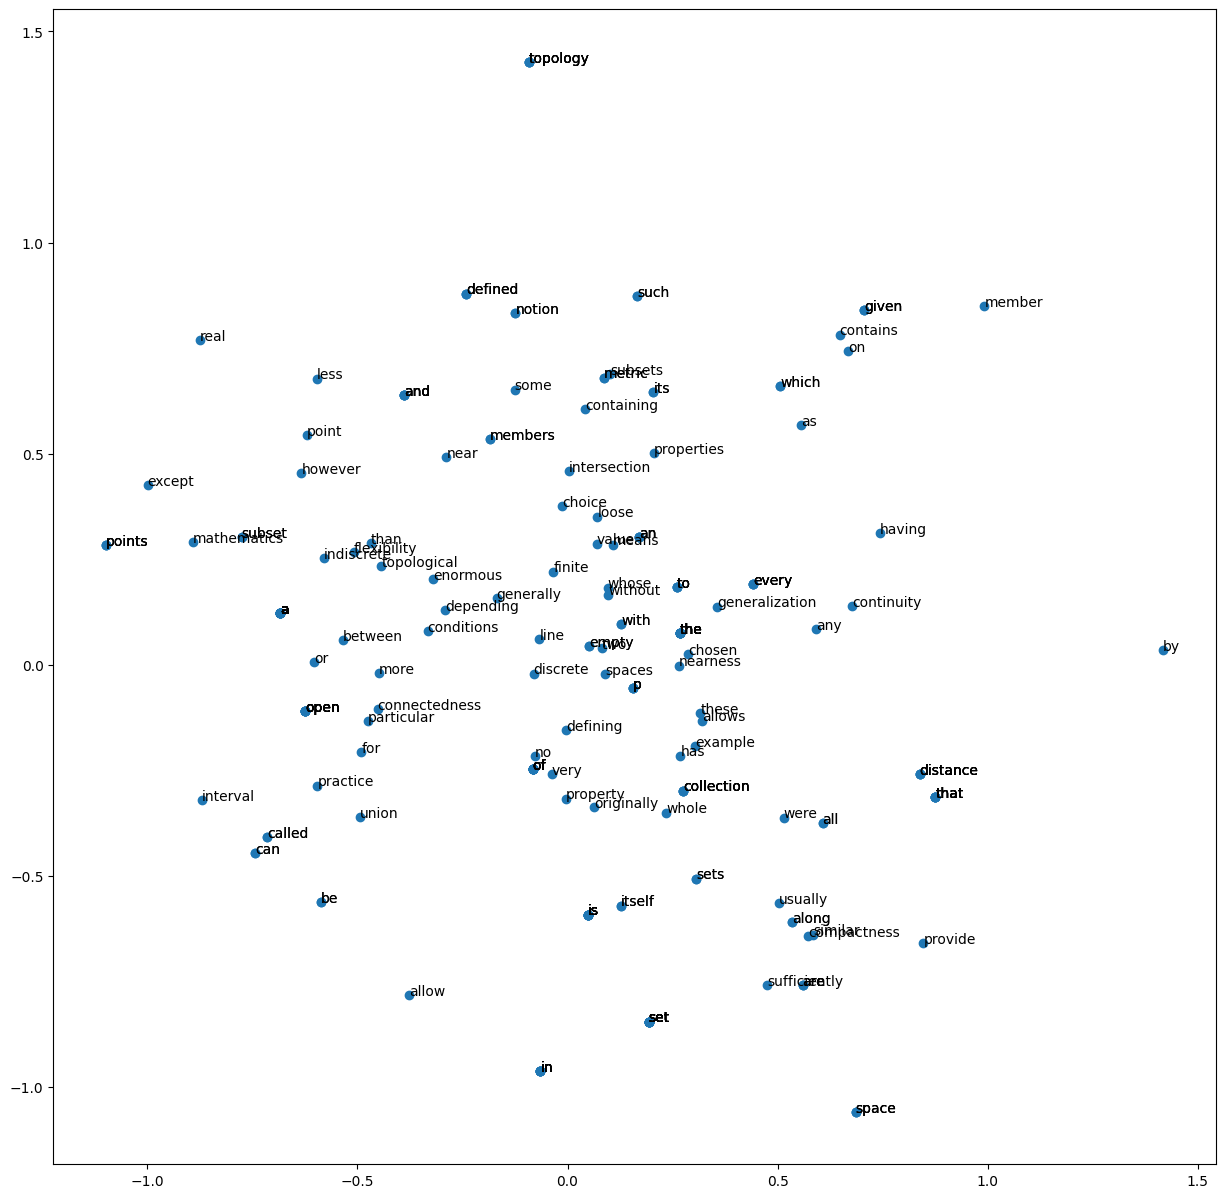

In [ ]:
if __name__ == '__main__':
  import matplotlib.pyplot as plt  # for plotting graphs
  def plot_semantic_space(dim1, dim2, words, weights, word_to_index, num_vocabs):
    """
    Plots dim1 against dim2 of the embedding of the words.
    Args:
      dim1: the first dimension to slice
      dim2: the second dimension to slice
      words: a list of words to plot
      weights: the embeddings learned by a model
    """
    coordinates = get_embeddings(words, weights, word_to_index, num_vocabs)[:, [dim1,dim2]]
    x_points = coordinates[:, 0]
    y_points = coordinates[:, 1]

    # use matplotlib to plot a scatter plot of the points
    plt.figure(figsize=(15, 15))
    plt.scatter(x_points, y_points)
    # label the points with the word corresponding to it
    for i in range(0, len(words)):
      plt.annotate(text=words[i], xy=coordinates[i])

  # extract the weights from the model
  weights_cbow = model_cbow.layers[0].get_weights()[0]
  weights_skipgram = model_skipgram.layers[0].get_weights()[0]
  # visualization
  plot_semantic_space(10, 20, words_in_order, weights_cbow, word_to_index, num_vocabs)

We can also use the skipgram method to find the closest context words!  Let's try to see what context words are closest to the words "open", "set", and "space".

In [ ]:
def context_words(word, top=10):
  """
  Finds the top few (default is 10) context words closest to the input word
  Args:
    word: the target word
    top:  specifies how many context words to find
  Returns:
    a list strings, which are the top few context words
  """
  # get the one-hot encoding of the word
  word_1hot = one_hot(np.array([word_to_index[word]]), num_vocabs)
  # get the model output
  output = model_cbow(word_1hot)[0]
  # get an array for the would-be sorted the output, from closest context words to furthest away context words
  sorted = np.argsort(-output)
  # check out which words they are
  return [index_to_word[s] for s in sorted][0:top]

if __name__ == '__main__':
  for w in ['open', 'set', 'space']:
    print(f"The 10 closest context words for '{w}' are: \t {context_words(w)}")

The 10 closest context words for 'open' are: 	 ['an', 'quiz', 'except', 'understand', 'swap', 'we', '001', 'is', 'source', '01']
The 10 closest context words for 'set' are: 	 ['full', 'theory', 'a', 'the', 'options', 'zeroes', 'term', 'isolated', '01', 'each']
The 10 closest context words for 'space' are: 	 ['3-dimensional', 'projected', 'is', 'position', 'riemann', 'message', 'under', 'anything', 'means', 'function']


Disregarding the words without much meaning (a, an, the, is, of, etc.), we can see that

- `"open"` is close to `"sets"`,
- `"set"` is close to `"open"`, and
- `"space"` is close to `"metric"` and `"topological"`.  

Looking back at the original text, this makes sense because, for example, `"open sets"` is a commonly appearing phrase, and so are `"metric space"` and `"topological space"`.

# **Section 5**  Training on the Wikipedia dataset (no tasks to complete)

To speed up training and make the process easier to debug, we used a sample text paragraph on open sets to train our Word2Vec model.  In practice, training is done using huge amounts of text, such as all Wikipedia articles instead.  There are two advantages to doing so:

- The model learns a much larger number of vocabs
- The embeddings are much more accurate because of the richer number of context words we can use during training.

Due to Google Colab's usage limits, it is only possible to train around 50 articles before exceeding Colab's usage limits.  Here, we provide some code for you to try this out.  It takes around 10 minutes to train 50 articles for 100 epochs using Colab's GPUs.

In [ ]:
if __name__ == '__main__':
  # uncommment and run to install necessary libs
  !pip install datasets # for loading wikipedia dataset
  !pip install apache_beam mwparserfromhell # for loading wikipedia dataset
  from datasets import load_dataset
  data = load_dataset("wikipedia", "20220301.simple")
  data = data['train']

  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.52.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.15 requires dill>=0.3.7, but you have dill 0.3.1.1 which is incompatible.


In [ ]:
# data is a list of 205328 dictionaries.
# data[index] is a dictionary containing keys ['id', 'url', 'title', 'text']
# here are all the article titles that are available

if __name__ == '__main__':
  titles = [d['title'].lower() for d in data]
  titles

In [ ]:
# You can search for articles you are interested in and extract them for training here
if __name__ == '__main__':
  keyword = "function"  # search for articles with this keyword in the title

  import re  # for text manipulation
  for i in range(len(data)):
    if (keyword.lower() in titles[i]):
      title = titles[i]
      content = re.sub('\n', ' ', data[i]['text'][0:100])
      print(f"{i} \t [{title}] \n\t\t {content}...")

4744 	 [function (mathematics)] 
		 In mathematics, a function is a mathematical object that produces an output, when given an input (wh...
8685 	 [hash function] 
		 The Hash function is a function. When a computer program is written, very often, large amounts of da...
13586 	 [euler's totient function] 
		 In number theory, the totient of a positive integer n is the number of positive integers smaller tha...
14001 	 [inverse function] 
		 An inverse function is a concept of mathematics. A function will calculate some output , given some ...
14003 	 [computable function] 
		 A computable function is an idea from computer science. A function is computable if there is an algo...
14346 	 [function] 
		 Function may mean:  professional or official position: Official  Function (mathematics), the relatio...
14580 	 [trigonometric function] 
		 In mathematics, the trigonometric functions are a set of functions which relate angles to the sides ...
16294 	 [prime counting function] 
		 In math

In [ ]:
# here are some additional articles related to mathematics.  You can change this to other articles if you want.
if __name__ == '__main__':
  articles = [    84,   4730,   4744,   8685,  13586,  14001,  14003,  14580,  14947,  16294,
              25619,  30722,  34985,  47604,  48341,  48342,  48372,  54734,  57684,  59006,
              59976,  63039,  71414,  71417,  71457,  71459,  73103,  73355,  77221,  82586,
              86760,  88644,  92842,  96710,  98679,  98964,  99261,  99749,  99866,  99990,
              117555, 117616, 121797, 123540, 127692, 131975, 134546, 150093, 152955, 162641,
              170979, 171477, 174654, 195383, 199312]
  print("The article titles:")
  print([data[i]['title'] for i in articles])

The article titles:
['Calculus', 'Differential calculus', 'Function (mathematics)', 'Hash function', "Euler's totient function", 'Inverse function', 'Computable function', 'Trigonometric function', 'Lambda calculus', 'Prime counting function', 'Exponential function', 'Limit of a function', 'Cryptographic hash function', 'Dirac delta function', 'One-way function', 'SHA hash functions', 'Riemann zeta function', 'Heaviside Function', 'Continuous function', 'Anonymous function', 'Periodic function', 'Fundamental theorem of calculus', 'Injective function', 'Surjective function', 'Vector calculus', 'Multivariable calculus', 'Functional programming', 'Multivalued function', 'Convex function', 'Wave function', 'Function composition', 'Gamma function', 'Holomorphic function', 'Function space', 'Linear predictor function', 'Loss function', 'Numerical integration', 'Calculus of variations', 'Constant function', 'Linear function', 'Probability density function', 'Root of a function', 'Unary functi

In [ ]:
# You can run this cell and comment out the "text" variable on open sets in the start of section 2, then run the notebook from the start.
# Around 100 epochs is enough for the skipgram model to converge

if __name__ == '__main__':
  text = ' '.join(data[i]['text'] for i in articles)

# **Appendix** (no tasks to complete)

**2D Semantic Space**

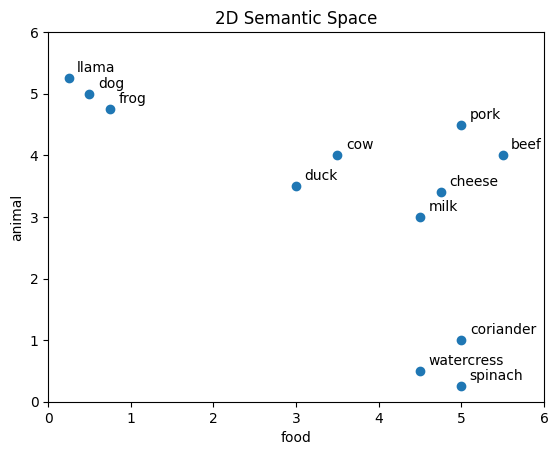

In [ ]:
# 2D Semantic Space
# Run this code cell to generate the image

if __name__ == '__main__':
  import matplotlib.pyplot as plt
  import numpy as np

  words = {
      "cow": [3.5, 4],          "duck": [3, 3.5],       "pork": [5, 4.5],      "beef": [5.5, 4],        "milk": [4.5, 3],      "cheese": [4.75, 3.4],
      "watercress": [4.5, 0.5], "spinach": [5, 0.25],   "coriander": [5, 1],   "llama": [0.25, 5.25],   "dog": [0.5, 5],       "frog": [0.75, 4.75]
  }

  # create a separate list for the words and the coordinates (separation is needed for matplotlib.pyplot)
  names, coordinates = [key for key in words.keys()], np.asarray([coord for coord in words.values()])
  x_points, y_points = coordinates[:, 0], coordinates[:, 1]

  # create a figure and axes object
  figure_2d = plt.figure()
  axes = figure_2d.add_subplot()

  # plot the points on the axes
  axes.scatter(x_points, y_points)

  # set the x and y axis limits
  axes.set_xlim(xmin=0, xmax=6)
  axes.set_ylim(ymin=0, ymax=6)

  # set the title of the figure
  axes.set_title("2D Semantic Space")

  # set the title of the x and y axes
  axes.set_xlabel("food")
  axes.set_ylabel("animal")

  # annotate the points
  for name, coordinate in zip(names, coordinates):
    axes.annotate(text=name, xy=coordinate+0.1)  # text is the label name, xy is the coordinate to place the text

  # figure_2d.show()

**3D Semantic Space**

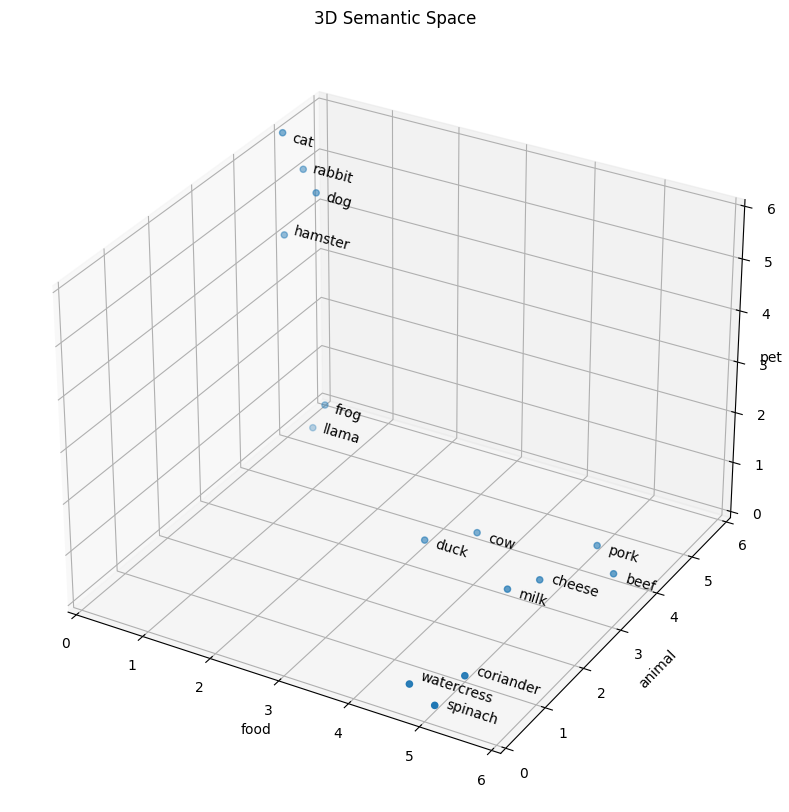

In [ ]:
# 3D Semantic Space
# Run this code cell to generate the image

if __name__ == '__main__':
  import matplotlib.pyplot as plt
  import numpy as np

  words = {
      "cow": [3.5, 4, 0],          "duck": [3, 3.5, 0],       "pork": [5, 4.5, 0],      "beef": [5.5, 4, 0],        "milk": [4.5, 3, 0],      "cheese": [4.75, 3.4, 0],
      "watercress": [4.5, 0.5, 0], "spinach": [5, 0.25, 0],   "coriander": [5, 1, 0],   "llama": [0.25, 5.25, 0],   "dog": [0.5, 5, 5],       "frog": [0.75, 4.75, 1],
      "cat": [0, 5, 6],            "rabbit": [0, 5.5, 5],     "hamster": [0, 5, 4]
  }

  # create a separate list for the words and the coordinates (separation is needed for matplotlib.pyplot)
  names, coordinates = [key for key in words.keys()], np.asarray([coord for coord in words.values()])
  x_points, y_points, z_points = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]

  # create a figure and axes object
  figure_3d = plt.figure(figsize=(15, 10))  # set figsize to enlarge the plot.  Enlargement is needed because the labels to the data points overlap
  axes = figure_3d.add_subplot(projection="3d")

  # plot the points on the axes
  axes.scatter(x_points, y_points, z_points)

  # set the x and y and z axis limits
  axes.set_xlim(xmin=0, xmax=6)
  axes.set_ylim(ymin=0, ymax=6)
  axes.set_zlim(zmin=0, zmax=6)

  # set the title of the figure
  axes.set_title("3D Semantic Space")

  # set the title of the x and y axes
  axes.set_xlabel("food")
  axes.set_ylabel("animal")
  axes.set_zlabel("pet")
  axes.zaxis.labelpad=-6  # matplotlib cuts off the z-axis label, adjust this to view z-axis label

  # # annotate the points
  for name, x, y, z in zip(names, x_points, y_points, z_points):
    axes.text(x+0.3, y-0.3, z, name, zdir=(1, 0, 0))  # zdir is a direction vector specifying which direction the text should be pointed at

  # figure_3d.show()

**One-hot encoding**

Let's say that given the properties of some items, we are trying to predict the color of the item.  The output (y) of the training data could be a list of colors as follows:

```
y = [red, green, yellow, red, red, blue]
```

Obviously, we need to use numbers to encode the output instead of color names.
We could simply map `red` to 0, `green` to 1, `yellow` to 2, and `blue` to 3 for training.  In other words, we use the following vector:

```
y_encoded = [0, 1, 2, 0, 0, 3]
```

However, this type of mapping implicitly assigns some form of "order" to the colors.  For example, by giving `blue` the label 3 and `yellow` the label 2, the model might somehow pick up some bias that `blue` is better than `yellow`.  To avoid this type of situation, we use one-hot encoding to encode the labels instead.  The one-hot encoding of `y` is a 2D array consisting of only 1s and 0s.  The details of how to create the one-hot encoding of `y` are:

- the 0th entry of the 0th row is 1
- the 1th entry of the 1st row is 1
- the 2th entry of the 2nd row is 1
- the 0th entry of the 3rd row is 1
- the 0th entry of the 4th row is 1
- the 3th entry of the 5th row is 1
- all other entries are 0

So, the one-hot encoding of `y` is
```
[[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1]]
```

As another example, if this was the original 1D array,

```
arr = [0, 2, 5, 1]
```

and there were 6 classes, then the one-hot encoding of `arr` would be:
```
[[1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0]]
```

Note that if there were some classes that no datum belonged to, then it is possible that some columns contain only 0.